# Subpockets to target residue(s)

We explore the distance of the `kissim` subpocket centers to their target residues.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from opencadd.databases.klifs import setup_remote
from kissim.encoding import FingerprintGenerator

from src.paths import PATH_DATA, PATH_RESULTS

In [3]:
plt.style.use("seaborn")

In [4]:
HERE = Path(_dh[-1])  # noqa: F821
DATA = PATH_DATA
RESULTS = PATH_RESULTS / "all"

In [5]:
REMOTE = setup_remote()

## Load subpocket center coordinates

In [6]:
fingerprint_generator = FingerprintGenerator.from_json(RESULTS / "fingerprints_clean.json")
print(f"Number of fingerprints: {len(fingerprint_generator.data)}")

Number of fingerprints: 4681


In [7]:
subpocket_centers = fingerprint_generator.subpocket_centers
subpocket_centers = subpocket_centers.stack(0)
subpocket_centers.index.names = ("structure.klifs_id", "subpocket")
subpocket_centers = subpocket_centers.reset_index()
subpocket_centers["residue.ix"] = 0
subpocket_centers

dimension,structure.klifs_id,subpocket,x,y,z,residue.ix
0,1,center,0.783500,22.267733,37.174877,0
1,1,dfg_region,7.576667,23.035334,34.537666,0
2,1,front_pocket,1.165333,17.645666,39.785000,0
3,1,hinge_region,1.416667,23.411001,41.720001,0
4,4,center,1.199345,20.814938,37.368965,0
...,...,...,...,...,...,...
18689,13863,hinge_region,4.361666,21.548668,42.100666,0
18690,13864,center,1.341892,20.782194,37.324520,0
18691,13864,dfg_region,8.026333,19.510332,34.528000,0
18692,13864,front_pocket,0.231000,18.350000,42.148335,0


## Define target residues

In [8]:
subpocket_to_residue_ixs = {
    "hinge_region": [46, 47, 48],
    "dfg_region": [81, 82, 83],
    "front_pocket": [4, 5, 6, 7, 8, 9],
}
subpocket_to_residue_ixs

{'hinge_region': [46, 47, 48],
 'dfg_region': [81, 82, 83],
 'front_pocket': [4, 5, 6, 7, 8, 9]}

In [9]:
residue_ix_to_subpocket = {
    residue_ix: subpocket
    for subpocket, residue_ixs in subpocket_to_residue_ixs.items()
    for residue_ix in residue_ixs
}
residue_ix_to_subpocket

{46: 'hinge_region',
 47: 'hinge_region',
 48: 'hinge_region',
 81: 'dfg_region',
 82: 'dfg_region',
 83: 'dfg_region',
 4: 'front_pocket',
 5: 'front_pocket',
 6: 'front_pocket',
 7: 'front_pocket',
 8: 'front_pocket',
 9: 'front_pocket'}

## Load pocket residue CA atom coordinates

In [10]:
ca_atoms = pd.read_csv(
    DATA / "processed/pocket_residue_ca_atom_coordinates.csv.gz", header=0, index_col=[0, 1]
)
# Rename a few columns and reset index
ca_atoms = ca_atoms.rename(columns={"atom.x": "x", "atom.y": "y", "atom.z": "z"})
ca_atoms = ca_atoms.reset_index()
# Keep only target residues
ca_atoms = ca_atoms[ca_atoms["residue.ix"].isin(residue_ix_to_subpocket.keys())]
# Add subpocket name
ca_atoms["subpocket"] = ca_atoms.apply(lambda x: residue_ix_to_subpocket[x["residue.ix"]], axis=1)
# Keep only structures that we have subpocket centers for
ca_atoms = ca_atoms[
    ca_atoms["structure.klifs_id"].isin(subpocket_centers["structure.klifs_id"].unique())
]
ca_atoms

,structure.klifs_id,residue.ix,x,y,z,subpocket
3,1,4,7.642,14.754,43.861,front_pocket
4,1,5,10.860,13.971,41.981,front_pocket
5,1,7,11.836,16.405,35.945,front_pocket
6,1,8,14.460,19.167,36.248,front_pocket
7,1,9,14.410,18.719,40.043,front_pocket
...,...,...,...,...,...,...
393582,13864,47,2.145,23.484,45.788,hinge_region
393583,13864,48,-1.590,24.034,45.313,hinge_region
393614,13864,81,2.577,18.822,33.603,dfg_region
393615,13864,82,2.393,21.136,30.594,dfg_region


## Concatenate CA atom and subpocket center data

In [11]:
coordinates = (
    pd.concat([ca_atoms, subpocket_centers])
    .sort_values(["structure.klifs_id", "subpocket"])
    .reset_index(drop=True)
)
coordinates.index.name = "ix"
coordinates

,structure.klifs_id,residue.ix,x,y,z,subpocket
ix,,,,,,
0,1,0,0.783500,22.267733,37.174877,center
1,1,81,0.495000,19.480000,32.809000,dfg_region
2,1,82,3.266000,17.284000,34.243000,dfg_region
3,1,83,5.132000,16.924000,30.908000,dfg_region
4,1,0,7.576667,23.035334,34.537666,dfg_region
...,...,...,...,...,...,...
73346,13864,0,0.231000,18.350000,42.148335,front_pocket
73347,13864,46,4.222000,26.199000,44.123000,hinge_region
73348,13864,47,2.145000,23.484000,45.788000,hinge_region


## Get vector between subpocket centers and their target residue CA atoms

In [12]:
vectors = coordinates.groupby(["structure.klifs_id", "subpocket"]).apply(
    lambda group: group[group["residue.ix"] != 0][["x", "y", "z"]]
    - group[group["residue.ix"] == 0][["x", "y", "z"]].squeeze()
)
vectors = (
    vectors.reset_index()
    .merge(coordinates.reset_index()[["ix", "residue.ix"]], how="left", on="ix")
    .set_index(["structure.klifs_id", "subpocket", "residue.ix"])
    .drop("ix", axis=1)
)
vectors

x         y         z
structure.klifs_id subpocket    residue.ix                              
1                  dfg_region   81         -7.081667 -3.555334 -1.728666
                                82         -4.310667 -5.751334 -0.294666
                                83         -2.444667 -6.111334 -3.629666
                   front_pocket 4           6.476667 -2.891666  4.076000
                                5           9.694667 -3.674666  2.196000
...                                              ...       ...       ...
13864              front_pocket 8           8.808000 -3.508000  2.117665
                                9           9.158000 -2.142000  5.642665
                   hinge_region 46         -0.018667  4.698666  2.035998
                                47         -2.095667  1.983666  3.700998
                                48         -5.830667  2.533666  3.225998

[54657 rows x 3 columns]

## Get vector length (distance)

In [13]:
distances = vectors.apply(lambda x: np.linalg.norm(x), axis=1)
distances = distances.unstack(0).transpose()
distances

subpocket          dfg_region                     front_pocket             \
residue.ix                 81        82        83           4          5    
structure.klifs_id                                                          
1                    8.110407  7.193505  7.516600     8.180631  10.597743   
4                    6.898447  6.630098  5.231835     7.643434   9.226580   
8                    6.393397  8.394686  6.744004     7.559248   9.617310   
9                    7.200447  8.716600  7.955971     9.364930   9.500966   
11                   7.237975  8.515901  6.093379     8.357121  10.724409   
...                       ...       ...       ...          ...        ...   
13855                6.440540  5.717690  4.015724     6.669069   9.179743   
13857                5.847393  6.564944  5.341949     7.340948  10.459580   
13862                5.737766  6.969237  6.276290    10.366287  13.575554   
13863                5.739994  7.350665  6.600001     9.782531  13.130122   
13864                5.569978  7.060707  6.417663     9.218292  12.164608   

subpocket                                                      hinge_region  \
residue.ix                 6          7          8          9            46   
structure.klifs_id                                                            
1                         NaN  11.408242  13.840989  13.290591     4.977981   
4                    8.499980  11.159090  12.884741  12.570443     5.003263   
8                    9.839860        NaN        NaN  10.673312     5.121003   
9                    7.443776   9.658435  11.401967  11.661492     4.729567   
11                  12.973671  14.884654  12.919863  12.291550     5.196987   
...                       ...        ...        ...        ...          ...   
13855               10.568157  13.994745  13.522273  10.804513     5.192098   
13857               11.793559  13.716211  11.586583  12.437102     4.821251   
13862               13.445759  12.013590  10.068031  11.234864     5.210427   
13863               13.596722  11.982083  10.175802  11.235391     5.261048   
13864               13.118150  11.604041   9.714496  10.967990     5.120850   

subpocket                               
residue.ix                47        48  
structure.klifs_id                      
1                   4.987418  6.200912  
4                   5.070012  6.234286  
8                   5.351008  6.489459  
9                   5.165569  6.569639  
11                  5.194417  6.448320  
...                      ...       ...  
13855               4.798345  6.459577  
13857               4.830278  6.769136  
13862               4.502902  7.013759  
13863               4.869803  7.705466  
13864               4.692988  7.129040  

[4681 rows x 12 columns]

## Plot distance distributions

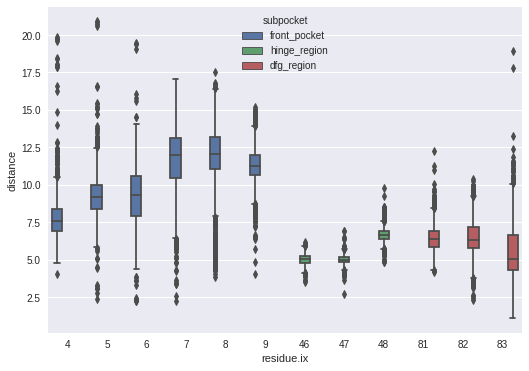

In [14]:
plt.figure(figsize=(8.5, 6))
ax = sns.boxplot(
    x="residue.ix",
    y="distance",
    hue="subpocket",
    data=distances.melt().sort_values("residue.ix").rename(columns={"value": "distance"}),
)

## Plot distance distributions split by DFG conformation

In [15]:
structures = REMOTE.structures.all_structures()

In [16]:
structure_klifs_ids_by_dfg = {
    name: group["structure.klifs_id"].to_list()
    for name, group in structures.groupby("structure.dfg")
}
distances_dict = {
    "All": distances,
    "DFG-in": distances[distances.index.isin(structure_klifs_ids_by_dfg["in"])],
    "DFG-out": distances[distances.index.isin(structure_klifs_ids_by_dfg["out"])],
}

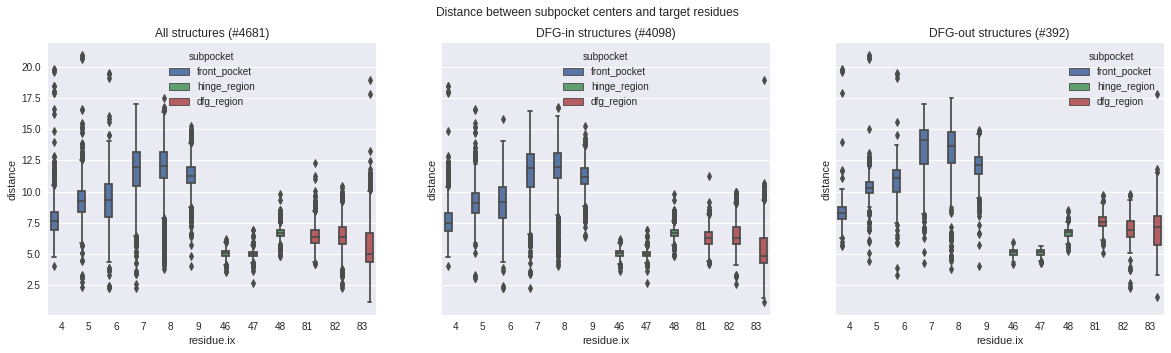

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharey=True)
fig.suptitle("Distance between subpocket centers and target residues")
for i, (title, data) in enumerate(distances_dict.items()):
    sns.boxplot(
        x="residue.ix",
        y="distance",
        hue="subpocket",
        data=data.melt().sort_values("residue.ix").rename(columns={"value": "distance"}),
        ax=axes[i],
    )
    axes[i].set_title(f"{title} structures (#{len(data)})")